In [1]:
##importing packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.000000,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.000000,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.000000,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.000000,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.000000,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,2,male,29.699118,0,0,C,26,Mr,Mr,1,1,1,4.019309,5,True,True,2.698841,2.698808,0.000000
664,1,3,female,0.750000,2,1,C,29,Miss,Miss,4,0,4,5.968428,4,False,True,3.008565,1.760441,0.038205
665,0,3,female,48.000000,1,3,S,39,Mrs,Mrs,5,0,4,1.312449,6,False,True,3.566005,2.261138,0.873952
666,0,1,male,47.000000,0,0,S,17,Mr,Mr,1,1,1,7.325721,4,False,False,3.676301,3.676301,0.797858


In [3]:

train["is_master"] = (train["title"].str.lower() == "master").astype(int)
test["is_master"]  = (test["title"].str.lower() == "master").astype(int)


In [4]:
train_analysis = train.copy()
le = LabelEncoder()
train_analysis['Sex'] = le.fit_transform(train_analysis['Sex'])


In [5]:
# here i am excluding the target 'Survived' and non-numeric columns
features_to_test = train_analysis.select_dtypes(include=['number']).drop(columns=['Survived'])
X_logic = features_to_test
y_logic = train_analysis['Survived']

In [6]:
#relation betweeen X and Y
importances = mutual_info_classif(X_logic, y_logic, random_state=42)
feat_importances = pd.Series(importances, index=X_logic.columns)

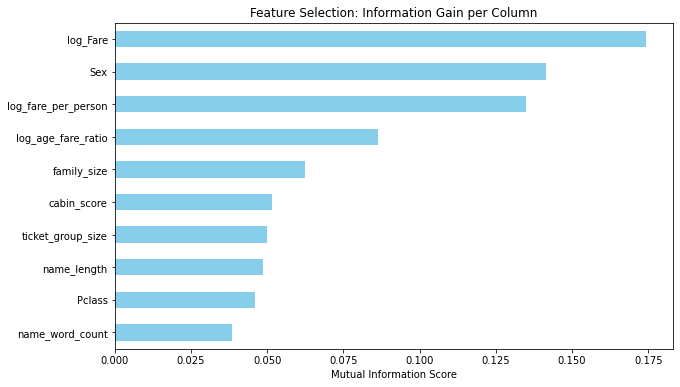

In [7]:
plt.figure(figsize=(10, 6))
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh', color='skyblue')
plt.title('Feature Selection: Information Gain per Column')
plt.xlabel('Mutual Information Score')
plt.show()

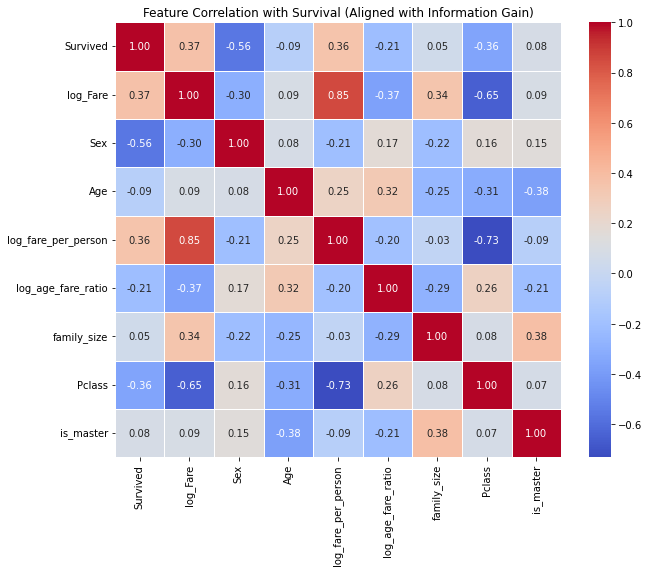

In [ ]:
# Correlation Heatmap to visualize relationships between features and target
le = LabelEncoder()
train_corr = train.copy()
train_corr['Sex'] = le.fit_transform(train_corr['Sex'])
validation_features = [
    'Survived', 'log_Fare', 'Sex','Age','log_fare_per_person', 
    'log_age_fare_ratio', 'family_size', 'Pclass', 'is_master'
]

# Create correlation matrix
corr_matrix = train[validation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation with Survival (Aligned with Information Gain)')
plt.show()

KNN is distance-based and sensitive to feature scale. Standardization is applied inside the pipeline (per CV fold) so no feature dominates and cross-validation stays leakage-free.


In [18]:
# Numerical features
num_features = ["log_Fare", "log_fare_per_person", "log_age_fare_ratio", "family_size", "Pclass", "Age"]
# Binary features
bin_features = ["is_master", "is_child", "is_alone"]
# Categorical features
cat_features = ["Sex", "Embarked", "title_group"]
# Preparing training set
X = train[num_features + bin_features + cat_features]
y = train["Survived"]
# Preparing matching test set
X_test_final = test[num_features + bin_features + cat_features]
y_test_final = test["Survived"]

# Internal split for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

To avoid data leakage in cross-validation, KNN is wrapped in a pipeline that standardizes features inside each CV fold. A stratified 5-fold split (shuffled, fixed seed) keeps class balance while tuning K, distance metric, and weighting.


In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing Pipeline
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()) # Critical for KNN distance math
    ]), num_features),
    ("bin", "passthrough", bin_features),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

# KNN Model Pipeline
pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

# Comprehensive Grid Search
param_grid = {
    "knn__n_neighbors": range(1, 41),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean"] # Testing both common distance types
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

#  Run Search
knn_grid.fit(X_train, y_train)
print(f"Optimal Parameters: {knn_grid.best_params_}")
print(f"Best Validation Accuracy: {knn_grid.best_score_:.4f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Optimal Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 19, 'knn__weights': 'uniform'}
Best Validation Accuracy: 0.8277


In [20]:
# Use the best estimator found by the Grid Search
y_pred = knn_grid.best_estimator_.predict(X_test_final)


all_features = num_features + bin_features + cat_features

print(f"Number of features used: {len(all_features)}")
print(f"Final Test Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
print("-" * 30)
print("Final Classification Report:")
print(classification_report(y_test_final, y_pred))


Number of features used: 12
Final Test Accuracy: 0.8072
------------------------------
Final Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       137
           1       0.75      0.74      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



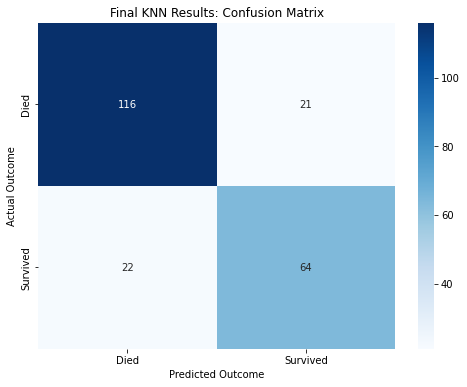

In [21]:

cm = confusion_matrix(y_test_final, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])

plt.title('Final KNN Results: Confusion Matrix')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

why did i chose k=19

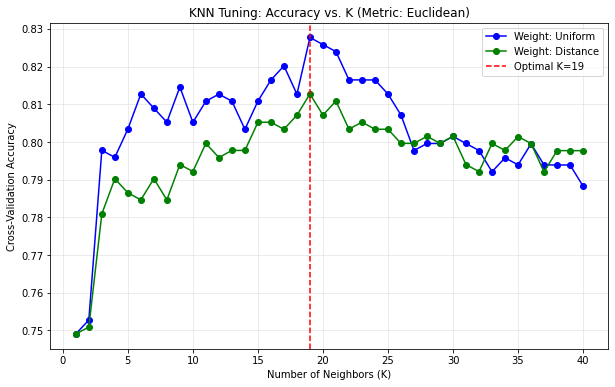

In [22]:
results = pd.DataFrame(knn_grid.cv_results_)

best_metric = knn_grid.best_params_['knn__metric']
best_k = knn_grid.best_params_['knn__n_neighbors']

plot_data = results[results['param_knn__metric'] == best_metric]

plt.figure(figsize=(10, 6))

uniform_data = plot_data[plot_data['param_knn__weights'] == 'uniform']
plt.plot(uniform_data['param_knn__n_neighbors'], uniform_data['mean_test_score'], 
         marker='o', label='Weight: Uniform', color='blue')

distance_data = plot_data[plot_data['param_knn__weights'] == 'distance']
plt.plot(distance_data['param_knn__n_neighbors'], distance_data['mean_test_score'], 
         marker='o', label='Weight: Distance', color='green')

plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal K={best_k}')
plt.title(f'KNN Tuning: Accuracy vs. K (Metric: {best_metric.capitalize()})')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ROC curve: visualizes true-positive vs. false-positive trade-offs for the tuned pipeline KNN model.


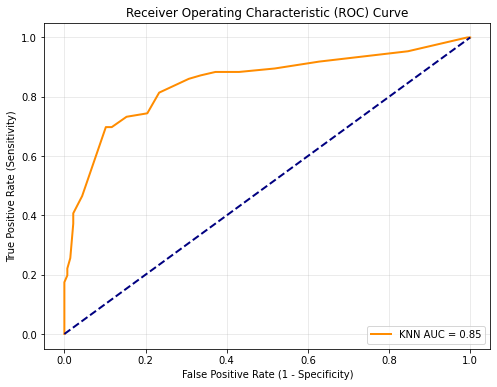

In [23]:
y_probs = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random baseline

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


### Model Evaluation:

Pipeline KNN (K=19) achieved about 80.72% test accuracy and an AUC of ~0.85. The ROC Curve shows a high true-positive rate while keeping false positives low, indicating reliable survival predictions on this dataset.
